# 零基础实战机器学习 源代码

第9讲 防止过拟合-Lasso和Ridge回归

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438

## 导入数据

In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


## 整理日期格式

In [2]:
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
print('日期范围（格式转化前）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
print('日期范围（格式转化后）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围（格式转化前）: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围（格式转化后）: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [3]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围（删除不完整的月份）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围（删除不完整的月份）: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


## 数据可视化

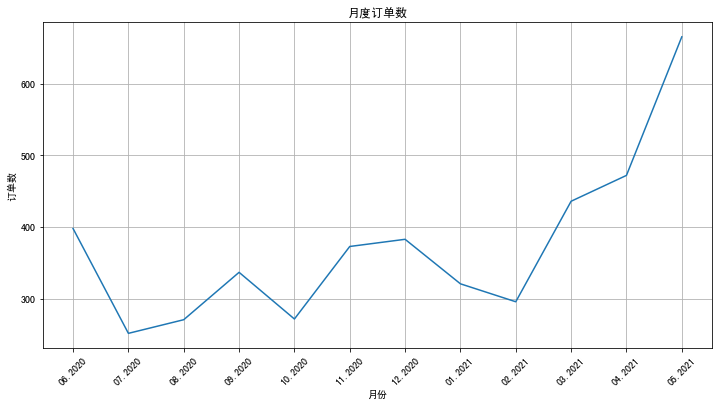

In [4]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
#构建月度的订单数的DataFrame
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

## 数据清洗

In [5]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

## 特征工程

In [6]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


## 构建User用户表

In [7]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14564,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14565,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14566,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14567,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


In [8]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user.columns = ['用户码'] #设定字段名
df_user.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user = pd.merge(df_user, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user = pd.merge(df_user, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user #显示用户表结构

,用户码,R值,F值,M值
0,15100,45,6,635.10
1,15291,35,35,1329.95
2,14688,6,85,1472.28
3,15311,5,715,12711.66
4,15862,89,64,354.23
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


### 构建标签

In [9]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,6,635.10,635.10
1,15291,35,35,1329.95,4596.51
2,14688,6,85,1472.28,4449.48
3,15311,5,715,12711.66,58218.04
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
365,15951,1,22,375.17,375.17
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


## 创建特征集和标签集

In [10]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

,R值,F值,M值
0,45,6,635.10
1,35,35,1329.95
2,6,85,1472.28
3,5,715,12711.66
4,89,64,354.23


In [11]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      635.10
1     4596.51
2     4449.48
3    58218.04
4      659.73
Name: 年度LTV, dtype: float64

## 拆分训练集、验证集和测试集

In [12]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 0)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 0)

In [13]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
scaler = MinMaxScaler() #创建归一化缩放器
X_train = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_valid = scaler.transform(X_valid) #转换验证集数据
X_test = scaler.transform(X_test) #转换测试集数据

## 选择算法创建模型

In [14]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
model_lr = LinearRegression() #创建线性回归模型
model_lasso = Lasso() #创建Lasso回归模型
model_ridge = Ridge() #创建Ridge回归模型

## 训练模型

In [15]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_lasso.fit(X_train, y_train) #拟合Lasso回归模型
model_ridge.fit(X_train, y_train) #拟合Ridge回归模型

Ridge()

## 评估模型

In [16]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('训练集上的R平方分数-线性回归: %0.4f' % r2_score(y_train, model_lr.predict(X_train)))
print('训练集上的R平方分数-Lasso回归: %0.4f' % r2_score(y_train, model_lasso.predict(X_train)))
print('训练集上的R平方分数-Ridge回归: %0.4f' % r2_score(y_train, model_ridge.predict(X_train)))
print('测试集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('测试集上的R平方分数-Lasso回归: %0.4f' % r2_score(y_valid, model_lasso.predict(X_valid)))
print('测试集上的R平方分数-Ridge回归: %0.4f' % r2_score(y_valid, model_ridge.predict(X_valid)))

训练集上的R平方分数-线性回归: 0.6749
训练集上的R平方分数-Lasso回归: 0.6748
训练集上的R平方分数-Ridge回归: 0.6368
测试集上的R平方分数-线性回归: 0.4647
测试集上的R平方分数-Lasso回归: 0.4667
测试集上的R平方分数-Ridge回归: 0.4988


### 绘图比较

C:\Users\jacky.huang\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jacky.huang\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


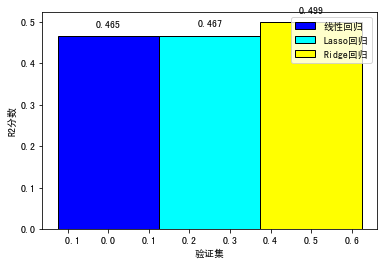

In [17]:
import numpy as np

fig, ax = plt.subplots()    
width = 0.25

# 柱子数据

bars1 = [r2_score(y_valid, model_lr.predict(X_valid))]
bars2 = [r2_score(y_valid, model_lasso.predict(X_valid))]
bars3 = [r2_score(y_valid, model_ridge.predict(X_valid))]
 
# 柱状图x轴位置
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
r3 = [x + width*2 for x in r1]
 
# 柱状图
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='线性回归')
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='Lasso回归')
plt.bar(r3, bars3, width = width, color = 'yellow', edgecolor = 'black', capsize=7, label='Ridge回归')

# 布局
plt.ylabel('R2分数')
plt.xlabel('验证集')
plt.legend()

# 数值标签
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')
addlabels(r1, bars1)
addlabels(r2, bars2)
addlabels(r3, bars3)

# 绘图
plt.show()